# Initial Setup

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/ITRPA_PROJ"
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs_colab")

req_path = os.path.join(BASE_DIR, "collab_requirements.txt")
!pip install -q -r "{req_path}"

Mounted at /content/drive


In [ ]:
def setup_paths(model_name: str):
    base = "/content/drive/MyDrive/ITRPA_PROJ"
    output = os.path.join(base, "outputs_colab")
    model_dir = os.path.join(output, model_name)
    os.makedirs(model_dir, exist_ok=True)
    return base, output, model_dir


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 13 13:51:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


# Imports

In [ ]:
import pickle
import json
import time
import psutil
import shutil

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from transformers import BertModel, BertTokenizer, Trainer, TrainingArguments, AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
import numpy as np

from torchview import draw_graph
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load Data

In [ ]:
DATA_DIR = os.path.join(BASE_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)

def load_datafile(data_filename="reviews.csv", base_dir=BASE_DIR):
    """
    Loads a CSV dataset, extracts Review and Label columns,
    maps numeric ratings (1–5) to sentiment categories,
    and label-encodes them for modeling.

    Mapping:
        1,2 → negative
        3   → neutral
        4,5 → positive

    Parameters
    ----------
    data_filename : str
        CSV filename (default: 'reviews.csv')
    base_dir : str
        Base directory (default: BASE_DIR)

    Returns
    -------
    X : pd.Series
        Text reviews
    y_encoded : np.ndarray
        Encoded sentiment labels (0=negative, 1=neutral, 2=positive)
    label_enc : LabelEncoder
        Fitted encoder mapping sentiments to integers
    """
    data_dir = os.path.join(base_dir, "data")
    os.makedirs(data_dir, exist_ok=True)

    data_path = os.path.join(data_dir, data_filename)
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"File not found: {data_path}")

    # Load and validate
    df = pd.read_csv(data_path)
    if not {"Review", "Label"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Review' and 'Label' columns.")

    # Extract X and y
    X = df["Review"].astype(str)
    y = pd.to_numeric(df["Label"], errors="coerce")

    # Validate label range
    if not y.dropna().between(1, 5).all():
        raise ValueError("Label column must contain numeric values 1–5.")

    # Map numeric labels to sentiment
    y_sentiment = y.map({1: "negative", 2: "negative",
                         3: "neutral",
                         4: "positive", 5: "positive"})

    # Encode sentiment labels
    label_enc = LabelEncoder()
    y_encoded = label_enc.fit_transform(y_sentiment)

    # Summary
    print(f"Loaded '{data_filename}' with shape {df.shape}")
    print("Sentiment distribution:")
    print(y_sentiment.value_counts())
    print("Label mapping:", dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))

    return X, y_encoded, label_enc

# Example usage
DATA_FILE = "reviews.csv"
X, y, label_enc = load_datafile(DATA_FILE)
print("Shapes:", X.shape, y.shape)

Loaded 'reviews.csv' with shape (107018, 3)
Sentiment distribution:
Label
positive    97227
neutral      5071
negative     4720
Name: count, dtype: int64
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Shapes: (107018,) (107018,)


# Train Test Split

In [ ]:
def prepare_splits(X, y, train_size=0.7, random_state=42):
    """
    Splits X and y into train, validation, and test sets,
    then fits and applies a LabelEncoder consistently across all.

    Parameters
    ----------
    X : array-like or DataFrame
        Input features.
    y : array-like or Series
        Target labels.
    train_size : float, default=0.7
        Proportion of data to use for training.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    X_train, X_val, X_test : arrays/DataFrames
        Feature splits.
    y_train_enc, y_val_enc, y_test_enc : arrays
        Encoded label splits.
    label_enc : LabelEncoder
        Fitted LabelEncoder instance.
    """

    # First split train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        train_size=train_size,
        random_state=random_state,
        stratify=y
    )

    # Split temp equally into val/test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=random_state,
        stratify=y_temp
    )

    # Label encode consistently across all sets
    label_enc = LabelEncoder()
    label_enc.fit(list(y_train) + list(y_val) + list(y_test))

    y_train_enc = label_enc.transform(y_train)
    y_val_enc   = label_enc.transform(y_val)
    y_test_enc  = label_enc.transform(y_test)

    # Print summary
    print(f" Train: {len(X_train)/len(X):.1%}")
    print(f" Val:   {len(X_val)/len(X):.1%}")
    print(f" Test:  {len(X_test)/len(X):.1%}")
    print("Classes found:", label_enc.classes_)

    return X_train, X_val, X_test, y_train_enc, y_val_enc, y_test_enc, label_enc

In [ ]:
X_train, X_val, X_test, y_train_enc, y_val_enc, y_test_enc, label_enc = prepare_splits(X, y)


 Train: 70.0%
 Val:   15.0%
 Test:  15.0%
Classes found: [0 1 2]


# Base Model Or Embedding and CONFIG

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
CONFIG = {
    # -------- Model & Architecture --------
    "model_name": "bert-base-uncased",
    "activation": "gelu",
    "hidden_size": 320,
    "dropout": 0.5,
    "fine_tune_base": True,
    "num_classes": 3,

    # -------- Tokenization & Data --------
    "max_len": 160,
    "batch_size": 32,

    # -------- Training --------
    "epochs": 3,
    "optimizer": "adamw",
    "loss_fn": "crossentropy",

    # -------- Learning Rates --------
    "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
    "lr_lstm": 1e-4,          # LSTM layer
    "lr_classifier": 1e-4,    # Classifier head

    # -------- Weight Decay --------
    "weight_decay_base": 0.01,  # Usually for pretrained encoder
    "weight_decay_others": 0.0, # Usually 0 for new layers

    # -------- Device --------
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}


In [ ]:
def load_base_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    base_model = AutoModel.from_pretrained(model_name)
    print(f"Loaded base model: {model_name}")
    return tokenizer, base_model

# Create Dataset Class

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create Modular Models

In [ ]:
class TransformerLSTMClassifier(nn.Module):
    def __init__(self, base_model, num_classes=3, input_size=768,
                 hidden_size=320, dropout=0.5, activation="relu",
                 fine_tune_base=True):
        super().__init__()

        self.base_model = base_model
        self.num_classes = num_classes
        self.input_size = input_size

        # Optionally freeze transformer layers
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune_base

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        # Dynamic activation lookup
        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "gelu": nn.GELU(),
            "leakyrelu": nn.LeakyReLU()
        }
        act = activations.get(activation.lower(), nn.ReLU())

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 80),
            act,
            nn.Linear(80, 20),
            act,
            nn.Linear(20, num_classes)
        )

    def forward(self, inputs):
        """
        inputs: dict from tokenizer (input_ids, attention_mask)
        returns: raw logits (not softmaxed)
        """
        transformer_out = self.base_model(**inputs)
        token_embeddings = transformer_out.last_hidden_state  # [batch, seq_len, hidden]
        lstm_out, _ = self.lstm(token_embeddings)
        last_hidden = lstm_out[:, -1, :]  # final timestep
        logits = self.classifier(last_hidden)
        return logits

In [ ]:
class TransformerBiLSTMClassifier(nn.Module):
    """
    Transformer + Bidirectional LSTM hybrid for sequence classification (Option 1: last time step).
    """

    def __init__(
        self,
        base_model,
        num_classes=3,
        input_size=768,
        hidden_size=320,
        dropout=0.5,
        activation="relu",
        fine_tune_base=True,
        bidirectional=True
    ):
        super().__init__()

        self.base_model = base_model
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # ---- Optionally fine-tune transformer ----
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune_base

        # ---- BiLSTM layer ----
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=bidirectional
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # ---- Activation lookup ----
        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "gelu": nn.GELU(),
            "leakyrelu": nn.LeakyReLU()
        }
        act = activations.get(activation.lower(), nn.ReLU())

        # ---- Classification head ----
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_size, 160),
            act,
            nn.Linear(160, 40),
            act,
            nn.Linear(40, num_classes)
        )

    def forward(self, inputs):
        """
        Args:
            inputs (dict): Tokenized batch (input_ids, attention_mask)
        Returns:
            logits (Tensor): [batch_size, num_classes]
        """
        # ---- Transformer encoder ----
        transformer_out = self.base_model(**inputs)
        token_embeddings = transformer_out.last_hidden_state  # [batch, seq_len, hidden]

        # ---- BiLSTM ----
        lstm_out, _ = self.lstm(token_embeddings)

        last_hidden = lstm_out[:, -1, :]  # [batch, hidden*2] if bidirectional=True

        # ---- Classification head ----
        logits = self.classifier(last_hidden)
        return logits

In [ ]:
class TransformerBiGRUClassifier(nn.Module):
    """
    Transformer + Bidirectional GRU hybrid for sequence classification (Option 1: last time step).
    """

    def __init__(
        self,
        base_model,
        num_classes=3,
        input_size=768,
        hidden_size=320,
        dropout=0.5,
        activation="relu",
        fine_tune_base=True,
        bidirectional=True
    ):
        super().__init__()

        self.base_model = base_model
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # ---- Optionally fine-tune transformer ----
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune_base

        # ---- BiGRU layer ----
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=bidirectional
        )

        gru_output_size = hidden_size * 2 if bidirectional else hidden_size

        # ---- Activation lookup ----
        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "gelu": nn.GELU(),
            "leakyrelu": nn.LeakyReLU()
        }
        act = activations.get(activation.lower(), nn.ReLU())

        # ---- Classification head ----
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(gru_output_size, 160),
            act,
            nn.Linear(160, 40),
            act,
            nn.Linear(40, num_classes)
        )

    def forward(self, inputs):
        """
        Args:
            inputs (dict): Tokenized batch (input_ids, attention_mask)
        Returns:
            logits (Tensor): [batch_size, num_classes]
        """
        # ---- Transformer encoder ----
        transformer_out = self.base_model(**inputs)
        token_embeddings = transformer_out.last_hidden_state  # [batch, seq_len, hidden]

        # ---- BiGRU ----
        gru_out, _ = self.gru(token_embeddings)

        # ---- Option 1: use last time step ----
        last_hidden = gru_out[:, -1, :]  # [batch, hidden*2] if bidirectional=True

        # ---- Classification head ----
        logits = self.classifier(last_hidden)
        return logits

In [ ]:
class TransformerRNNClassifier(nn.Module):
    """
    Transformer + single-layer RNN hybrid for sequence classification (uses last time step).
    """

    def __init__(
        self,
        base_model,
        num_classes=3,
        input_size=768,
        hidden_size=320,
        dropout=0.5,
        activation="relu",
        fine_tune_base=True
    ):
        super().__init__()

        self.base_model = base_model
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size

        # ---- Optionally fine-tune transformer ----
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune_base

        # ---- RNN layer ----
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        # ---- Activation lookup ----
        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "gelu": nn.GELU(),
            "leakyrelu": nn.LeakyReLU()
        }
        act = activations.get(activation.lower(), nn.ReLU())

        # ---- Classification head ----
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 160),
            act,
            nn.Linear(160, 40),
            act,
            nn.Linear(40, num_classes)
        )

    def forward(self, inputs):
        """
        Args:
            inputs (dict): Tokenized batch (input_ids, attention_mask)
        Returns:
            logits (Tensor): [batch_size, num_classes]
        """
        # ---- Transformer encoder ----
        transformer_out = self.base_model(**inputs)
        token_embeddings = transformer_out.last_hidden_state  # [batch, seq_len, hidden]

        # ---- RNN ----
        rnn_out, _ = self.rnn(token_embeddings)

        # ---- Option: use last time step ----
        last_hidden = rnn_out[:, -1, :]  # [batch, hidden]

        # ---- Classification head ----
        logits = self.classifier(last_hidden)
        return logits

In [ ]:
class TransformerCNNClassifier(nn.Module):
    """
    Transformer + TextCNN hybrid for sequence classification.
    Uses multiple convolutional filters over the token embeddings.
    """

    def __init__(
        self,
        base_model,
        num_classes=3,
        filter_sizes=(2, 3, 4),
        num_filters=100,
        dropout=0.5,
        fine_tune_base=True
    ):
        super().__init__()
        self.base_model = base_model
        self.num_classes = num_classes
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters

        # ---- Optionally fine-tune Transformer ----
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune_base

        # ---- TextCNN convolution layers ----
        # Each Conv2D kernel slides over tokens (height) and full embedding dim (width)
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=1,
                out_channels=num_filters,
                kernel_size=(k, self.base_model.config.hidden_size)
            )
            for k in filter_sizes
        ])

        # ---- Classification head ----
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_filters * len(filter_sizes), 128),
            nn.GELU(),
            nn.Linear(128, 32),
            nn.GELU(),
            nn.Linear(32, num_classes)
        )

    def conv_block(self, x, conv):
        """
        Applies one convolution + ReLU + max pooling block.
        Args:
            x: [batch, 1, seq_len, hidden_size]
            conv: nn.Conv2d
        Returns:
            out: [batch, num_filters]
        """
        x = conv(x)                 # [batch, num_filters, seq_len - k + 1, 1]
        x = F.relu(x)
        x = x.squeeze(3)            # remove last dim → [batch, num_filters, seq_len - k + 1]
        x = F.max_pool1d(x, x.size(2))  # pool over time
        out = x.squeeze(2)          # [batch, num_filters]
        return out

    def forward(self, inputs):
        # ---- Transformer encoder ----
        transformer_out = self.base_model(**inputs)
        token_embeddings = transformer_out.last_hidden_state  # [batch, seq_len, hidden]
        token_embeddings = token_embeddings.unsqueeze(1)      # [batch, 1, seq_len, hidden]

        # ---- CNN feature extraction ----
        cnn_outs = [self.conv_block(token_embeddings, conv) for conv in self.convs]
        cnn_out = torch.cat(cnn_outs, dim=1)  # [batch, num_filters * len(filter_sizes)]

        # ---- Classification head ----
        logits = self.classifier(cnn_out)
        return logits

# Create Optimizer and Loss function Helpers

In [ ]:
def build_optimizer(
    model,
    optimizer_name="adamw",
    lr_base=2e-5,
    lr_lstm=1e-4,
    lr_classifier=1e-4,
    weight_decay_base=0.01,
    weight_decay_others=0.0,
):
    """
    Build an optimizer with explicit learning rates for:
      - Transformer base (BERT/Roberta/etc.)
      - Recurrent block (RNN/LSTM/GRU)
      - Classifier head

    Args:
        model (nn.Module): Model with attributes like .bert, .roberta, .base_model, .rnn/.gru/.lstm, and .classifier
        optimizer_name (str): 'adamw', 'adam', or 'sgd'
        lr_base (float): learning rate for transformer/base model
        lr_lstm (float): learning rate for RNN/LSTM/GRU
        lr_classifier (float): learning rate for classifier head
        weight_decay_base (float): weight decay for base model
        weight_decay_others (float): weight decay for RNN/classifier
    """
    name = optimizer_name.lower()
    opt_classes = {
        "adamw": torch.optim.AdamW,
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
    }
    if name not in opt_classes:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # ---------------- Identify base transformer model ----------------
    base_model = None
    for attr in ["bert", "roberta", "distilbert", "base_model"]:
        if hasattr(model, attr):
            base_model = getattr(model, attr)
            break

    base_params = list(base_model.parameters()) if base_model is not None else []

    # ---------------- Identify recurrent layer ----------------
    rnn_params = []
    for attr in ["rnn", "gru", "bigru", "lstm"]:
        if hasattr(model, attr):
            rnn_params = list(getattr(model, attr).parameters())
            break

    # ---------------- Identify classifier head ----------------
    cls_params = list(model.classifier.parameters()) if hasattr(model, "classifier") else []

    # ---------------- Build parameter groups ----------------
    param_groups = []
    if base_params:
        param_groups.append({
            "params": base_params,
            "lr": lr_base,
            "weight_decay": weight_decay_base
        })
    if rnn_params:
        param_groups.append({
            "params": rnn_params,
            "lr": lr_lstm,
            "weight_decay": weight_decay_others
        })
    if cls_params:
        param_groups.append({
            "params": cls_params,
            "lr": lr_classifier,
            "weight_decay": weight_decay_others
        })

    # Fallback if nothing detected
    if not param_groups:
        param_groups = [{
            "params": model.parameters(),
            "lr": lr_base,
            "weight_decay": weight_decay_base
        }]
        print("No specific groups found — using all model parameters as one group.")

    # ---------------- Create optimizer ----------------
    if name == "sgd":
        optimizer = opt_classes[name](param_groups, momentum=0.9)
    else:
        optimizer = opt_classes[name](param_groups)

    # ---------------- Summary printout ----------------
    print("Optimizer parameter groups:")
    for i, g in enumerate(optimizer.param_groups):
        n_params = sum(p.numel() for p in g["params"])
        print(f"  Group {i}: lr={g['lr']:.1e}, weight_decay={g['weight_decay']}, n_params={n_params}")

    return optimizer

In [ ]:
def build_loss(loss_name, class_weights=None):
    loss_name = loss_name.lower()

    if loss_name == "crossentropy":
        if class_weights is not None:
            return nn.CrossEntropyLoss(weight=class_weights)
        return nn.CrossEntropyLoss()

    elif loss_name == "bce":
        return nn.BCEWithLogitsLoss()

    elif loss_name == "mse":
        return nn.MSELoss()

    else:
        raise ValueError(f"Unsupported loss: {loss_name}")

In [ ]:
def compute_class_weights(y_train, device):
    """
    Compute balanced class weights for CrossEntropyLoss.

    Args:
        y_train: array-like of encoded class labels (e.g., [0, 1, 2, 2, 0, ...])
        device: torch.device to move the tensor to (e.g., 'cuda' or 'cpu')

    Returns:
        class_weights: torch.Tensor of shape [num_classes]
        weights_dict:  dict mapping class_id -> weight (for logging)
    """
    y_train = np.array(y_train)
    classes = np.unique(y_train)

    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )

    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    weights_dict = dict(zip(classes.tolist(), weights.tolist()))

    print("Computed class weights:", weights_dict)
    return class_weights, weights_dict

# Create Data Loader Class

In [ ]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test,
                       tokenizer, max_len, batch_size):
    def make_loader(X, y, shuffle, balance=False):
        dataset = TextDataset(
            texts=X.tolist() if hasattr(X, "tolist") else list(X),
            labels=y.tolist() if hasattr(y, "tolist") else list(y),
            tokenizer=tokenizer,
            max_len=max_len
        )

        if balance:
            labels = np.array(y)
            class_counts = np.bincount(labels)
            class_weights = 1.0 / np.maximum(class_counts, 1)
            sample_weights = class_weights[labels]
            sampler = WeightedRandomSampler(
                weights=torch.DoubleTensor(sample_weights),
                num_samples=len(sample_weights),
                replacement=True
            )
            return DataLoader(dataset, batch_size=batch_size, sampler=sampler)
        else:
            return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    train_loader = make_loader(X_train, y_train, shuffle=False, balance=True)   # For training
    train_eval_loader = make_loader(X_train, y_train, shuffle=False, balance=False)  # For eval
    val_loader   = make_loader(X_val, y_val, shuffle=False)
    test_loader  = make_loader(X_test, y_test, shuffle=False)

    print(f"Dataloaders ready — Train: {len(train_loader.dataset)}, "
          f"Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")
    return train_loader, train_eval_loader, val_loader, test_loader


# Define Training Loop

In [ ]:
def train_and_evaluate(
    model, train_loader, val_loader,
    optimizer, criterion, device,
    model_name, model_dir,
    epochs=3
):
    """
    Train and evaluate model, log accuracy/loss/timing + environment info.
    """
    os.makedirs(model_dir, exist_ok=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    epoch_times = []

    model.to(device)
    overall_start = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()

        # ---------------- TRAIN ----------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ---------------- VALIDATE ----------------
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False):
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device)
                }
                labels = batch["labels"].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}% | "
              f"Time: {epoch_time/60:.2f} min")

    total_time = time.time() - overall_start
    avg_epoch_time = total_time / epochs

    # ---------------- ENVIRONMENT INFO ----------------
    gpu_info = {}
    if torch.cuda.is_available():
        gpu_props = torch.cuda.get_device_properties(device)
        gpu_info = {
            "gpu_name": gpu_props.name,
            "total_vram_gb": round(gpu_props.total_memory / 1e9, 2),
            "allocated_vram_gb": round(torch.cuda.memory_allocated(device) / 1e9, 2),
            "reserved_vram_gb": round(torch.cuda.memory_reserved(device) / 1e9, 2),
            "cuda_version": torch.version.cuda
        }

    # RAM and disk
    ram = psutil.virtual_memory()
    disk = shutil.disk_usage('/')
    env_info = {
        "python_version": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}",
        "torch_version": torch.__version__,
        "device": str(device),
        "gpu_info": gpu_info,
        "ram_used_gb": round((ram.total - ram.available) / 1e9, 2),
        "ram_total_gb": round(ram.total / 1e9, 2),
        "disk_used_gb": round(disk.used / 1e9, 2),
        "disk_total_gb": round(disk.total / 1e9, 2)
    }

    # ---------------- LOG TIMING + ENV ----------------
    os.makedirs(model_dir, exist_ok=True)
    timing_log = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "total_time_sec": round(total_time, 2),
        "total_time_min": round(total_time / 60, 2),
        "avg_epoch_time_sec": round(avg_epoch_time, 2),
        "epoch_times_sec": [round(t, 2) for t in epoch_times],
        "environment": env_info
    }

    log_path = os.path.join(model_dir, f"{model_name}_timing_log.json")
    with open(log_path, "w") as f:
        json.dump(timing_log, f, indent=4)

    print(f"\n✅ Training complete in {total_time/60:.2f} min "
          f"({avg_epoch_time:.2f} sec/epoch avg)")
    print(f"⏱ Timing + environment info saved to: {log_path}")

    # ---------------- PLOTS ----------------
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label="Val Loss", marker='o')
    plt.title(f"{model_name} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(model_dir, f"{model_name}_training_loss.png"), bbox_inches="tight")
    plt.close()

    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs + 1), train_accs, label="Train Accuracy", marker='o')
    plt.plot(range(1, epochs + 1), val_accs, label="Val Accuracy", marker='o')
    plt.title(f"{model_name} Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(model_dir, f"{model_name}_training_accuracy.png"), bbox_inches="tight")
    plt.close()

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "timing_log": timing_log
    }


# Define Model Graph Function

In [ ]:
def save_model_graph(model, dataloader, model_name, model_dir, device, show_backbone=True):
    model.eval()
    batch = next(iter(dataloader))
    inputs = {
        "input_ids": batch["input_ids"].to(device),
        "attention_mask": batch["attention_mask"].to(device)
    }

    if not show_backbone:
        class DummyBase(nn.Module):
            def __init__(self, hidden_size=768):
                super().__init__()
                self.config = type('obj', (object,), {"hidden_size": hidden_size})

            def forward(self, **kwargs):
                batch_size = kwargs["input_ids"].shape[0]
                seq_len = kwargs["input_ids"].shape[1]
                hidden_size = self.config.hidden_size
                return type('obj', (object,), {
                    "last_hidden_state": torch.randn(
                        batch_size, seq_len, hidden_size,
                        device=kwargs["input_ids"].device
                    )
                })

        model.base_model = DummyBase()

    class TorchViewWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        def forward(self, inputs):
            return self.model(inputs)

    wrapped_model = TorchViewWrapper(model).to(device)
    wrapped_model.eval()

    graph = draw_graph(
        wrapped_model,
        input_data=(inputs,),
        expand_nested=True,
        depth=4,
        device=device,
        save_graph=True,
        directory=model_dir,
        filename=f"{model_name.replace('/', '_')}_graph"
    )

    print(f"✅ Saved model graph to: {model_dir}/{model_name.replace('/', '_')}_graph.png")
    return graph


# Define Evaluation Loop

In [ ]:
def evaluate_model(
    model,
    test_loader,
    label_encoder,
    device,
    model_name,
    model_dir,
    num_classes=3,
    train_acc_final=None,
    config=None
):
    """
    Evaluate a trained model on the test set and visualize key metrics.

    Saves:
        - classification_report.json
        - roc_auc.png
        - confusion_matrix.png
        - accuracy_barplot.png (if train_acc_final provided)
    """
    os.makedirs(model_dir, exist_ok=True)

    # ---------------- Save CONFIG ----------------
    if config is not None:
        config_path = os.path.join(model_dir, f"{model_name}_config.json")
        with open(config_path, "w") as f:
            json.dump(config, f, indent=4, default=str)
        print(f"Config saved → {config_path}")

    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_name}", leave=False):
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }
            labels = batch["labels"].to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    preds = np.array(all_preds)
    probs = np.array(all_probs)
    labels = np.array(all_labels)

    # Decode to class names
    y_true = label_encoder.inverse_transform(labels)
    y_pred = label_encoder.inverse_transform(preds)
    class_names = label_encoder.classes_

    # ---------------- Classification report ----------------
    report = classification_report(
        y_true, y_pred, target_names=class_names,
        output_dict=True, zero_division=0
    )
    report = {str(k): v for k, v in report.items()}
    report_path = os.path.join(model_dir, f"{model_name}_classification_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
    print(f"Classification report saved → {report_path}")

    # ---------------- ROC-AUC ----------------
    y_true_bin = label_binarize(labels, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        # Some classes might not appear in test set → handle safely
        if y_true_bin[:, i].sum() == 0:
            fpr[i], tpr[i], roc_auc[i] = [0], [0], 0.0
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro AUC (multi-class One-vs-Rest)
    macro_auc = roc_auc_score(
        y_true_bin, probs, average="macro", multi_class="ovr"
    )

    plt.figure(figsize=(7, 6))
    for i, name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC={roc_auc[i]:.3f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.title(f"{model_name} ROC Curves (Macro AUC={macro_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)

    roc_path = os.path.join(model_dir, f"{model_name}_roc_auc.png")
    plt.savefig(roc_path, bbox_inches="tight")
    plt.close()
    print(f"ROC-AUC plot saved → {roc_path}")



# USAGE

In [ ]:
# MODEL_NAME = "bert_lstm_relu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG['model_name']     = "bert-base-uncased"
# CONFIG['activation']     = "relu"
# CONFIG['hidden_size']    = 320
# CONFIG['dropout']        = 0.5
# CONFIG['fine_tune_base'] = True
# CONFIG['num_classes']    = 3

# CONFIG['max_len']        = 128
# CONFIG['batch_size']     = 16

# CONFIG['epochs']         = 2
# CONFIG['learning_rate']  = 2e-5
# CONFIG['optimizer']      = "adamw"
# CONFIG['loss_fn']        = "crossentropy"

# CONFIG['device']         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------
# model = TransformerLSTMClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG['num_classes'],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG['hidden_size'],
#     dropout        = CONFIG['dropout'],
#     activation     = CONFIG['activation'],
#     fine_tune_base = CONFIG['fine_tune_base']
# ).to(CONFIG['device'])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(model, CONFIG["optimizer"], CONFIG["learning_rate"])
# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )




# BERT LSTM GELU ACTIVATION

In [ ]:
# MODEL_NAME = "bert_lstm_gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "bert-base-uncased",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 32,

#     # -------- Training --------
#     "epochs": 3,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 1e-4,          # LSTM layer
#     "lr_classifier": 1e-4,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerLSTMClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG['num_classes'],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG['hidden_size'],
#     dropout        = CONFIG['dropout'],
#     activation     = CONFIG['activation'],
#     fine_tune_base = CONFIG['fine_tune_base']
# ).to(CONFIG['device'])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name="adamw",
#     lr_base=2e-5,          # BERT/Roberta backbone
#     lr_lstm=1e-4,          # LSTM
#     lr_classifier=1e-4,    # Classifier head
#     weight_decay_base=0.01,
#     weight_decay_others=0.0
# )

# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# RoBERTa LSTM

In [ ]:
# MODEL_NAME = "roberta_lstm_gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "roberta-base",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerLSTMClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG['num_classes'],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG['hidden_size'],
#     dropout        = CONFIG['dropout'],
#     activation     = CONFIG['activation'],
#     fine_tune_base = CONFIG['fine_tune_base']
# ).to(CONFIG['device'])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# BERT BiLSTM GELU

In [ ]:
# MODEL_NAME = "bert_bi_lstm_gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "bert-base-uncased",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerBiLSTMClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG["hidden_size"],
#     dropout        = CONFIG["dropout"],
#     activation     = CONFIG["activation"],
#     fine_tune_base = CONFIG["fine_tune_base"],
#     bidirectional  = True
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# Roberta BI-LSTM GELU

In [ ]:
# MODEL_NAME = "roberta_bi_lstm_gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "roberta-base",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 3,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerBiLSTMClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG["hidden_size"],
#     dropout        = CONFIG["dropout"],
#     activation     = CONFIG["activation"],
#     fine_tune_base = CONFIG["fine_tune_base"],
#     bidirectional  = True
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# Bert GRU Gelu

In [ ]:
# MODEL_NAME = "bert-gru-gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "bert-base-uncased",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerBiGRUClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG["hidden_size"],
#     dropout        = CONFIG["dropout"],
#     activation     = CONFIG["activation"],
#     fine_tune_base = CONFIG["fine_tune_base"],
#     bidirectional  = True
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# ROBERTA GRU GELU

In [ ]:
# MODEL_NAME = "roberta-gru-gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "roberta-base",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerBiGRUClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG["hidden_size"],
#     dropout        = CONFIG["dropout"],
#     activation     = CONFIG["activation"],
#     fine_tune_base = CONFIG["fine_tune_base"],
#     bidirectional  = True
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# BERT RNN GELU

In [ ]:
# MODEL_NAME = "bert-rnn-gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "bert-base-uncased",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerRNNClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG["hidden_size"],
#     dropout        = CONFIG["dropout"],
#     activation     = CONFIG["activation"],
#     fine_tune_base = CONFIG["fine_tune_base"],
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# ROBERTA RNN GELU

In [ ]:
# MODEL_NAME = "roberta-rnn-gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "roberta-base",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerRNNClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     input_size     = base_model.config.hidden_size,
#     hidden_size    = CONFIG["hidden_size"],
#     dropout        = CONFIG["dropout"],
#     activation     = CONFIG["activation"],
#     fine_tune_base = CONFIG["fine_tune_base"],
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# BERT CNN GELU

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loaded base model: bert-base-uncased
Computed class weights: {0: 7.557707828894269, 1: 7.0339906103286385, 2: 0.36690273981995747}
Computed class weights: {0: 7.557707828894269, 1: 7.0339906103286385, 2: 0.36690273981995747}


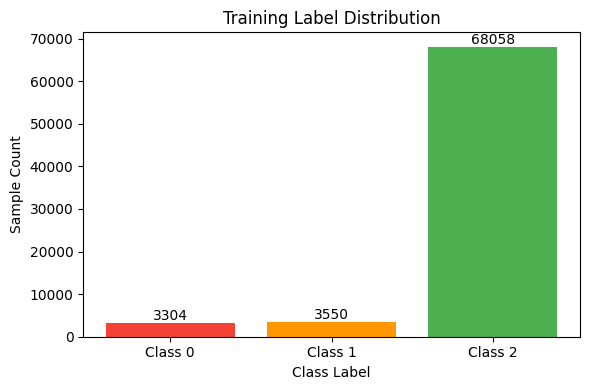

Optimizer parameter groups:
  Group 0: lr=2.0e-05, weight_decay=0.01, n_params=109482240
  Group 1: lr=2.0e-05, weight_decay=0.0, n_params=42755
Dataloaders ready — Train: 74912, Val: 16053, Test: 16053
Input data device: cpu


Epoch 01/2 | Train Loss: 0.5486, Val Loss: 0.3095 | Train Acc: 79.40%, Val Acc: 88.95% | Time: 16.39 min


Epoch 02/2 | Train Loss: 0.2302, Val Loss: 0.3032 | Train Acc: 93.38%, Val Acc: 90.81% | Time: 16.41 min

✅ Training complete in 32.80 min (984.12 sec/epoch avg)
⏱ Timing + environment info saved to: /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert-cnn-gelu/bert-cnn-gelu_timing_log.json
✅ Saved model graph to: /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert-cnn-gelu/bert-base-uncased_graph.png
Config saved → /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert-cnn-gelu/bert-cnn-gelu_config.json


Classification report saved → /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert-cnn-gelu/bert-cnn-gelu_classification_report.json
ROC-AUC plot saved → /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert-cnn-gelu/bert-cnn-gelu_roc_auc.png


In [ ]:
# MODEL_NAME = "bert-cnn-gelu"
# MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
# os.makedirs(MODEL_DIR, exist_ok=True)

# # ---------------- CONFIG ----------------
# CONFIG = {
#     # -------- Model & Architecture --------
#     "model_name": "bert-base-uncased",
#     "activation": "gelu",
#     "hidden_size": 320,
#     "dropout": 0.5,
#     "fine_tune_base": True,
#     "num_classes": 3,

#     # -------- Tokenization & Data --------
#     "max_len": 160,
#     "batch_size": 128,

#     # -------- Training --------
#     "epochs": 2,
#     "optimizer": "adamw",
#     "loss_fn": "crossentropy",

#     # -------- Learning Rates --------
#     "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
#     "lr_lstm": 2e-5,          # LSTM layer
#     "lr_classifier": 2e-5,    # Classifier head

#     # -------- Weight Decay --------
#     "weight_decay_base": 0.01,  # Usually for pretrained encoder
#     "weight_decay_others": 0.0, # Usually 0 for new layers

#     # -------- Device --------
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
# }


# # ---------------- Load tokenizer + transformer ----------------
# tokenizer, base_model = load_base_model(CONFIG["model_name"])

# # ---------------- Initialize model ----------------

# model = TransformerCNNClassifier(
#     base_model     = base_model,
#     num_classes    = CONFIG["num_classes"],
#     filter_sizes   = (2, 3, 4),
#     num_filters    = 100,
#     dropout        = CONFIG["dropout"],
#     fine_tune_base = CONFIG["fine_tune_base"]
# ).to(CONFIG["device"])

# # ---------------- Compute Class Weights ----------------
# class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
# print("Computed class weights:", weights_dict)

# # --- Visualize class distribution ---
# y_train_np = np.array(y_train_enc)
# unique, counts = np.unique(y_train_np, return_counts=True)

# plt.figure(figsize=(6, 4))
# plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
# plt.xticks(unique, [f"Class {c}" for c in unique])
# plt.title("Training Label Distribution")
# plt.xlabel("Class Label")
# plt.ylabel("Sample Count")

# for i, count in enumerate(counts):
#     plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

# plt.tight_layout()
# plt.show()

# # ---------------- Optimizer and loss ----------------
# optimizer = build_optimizer(
#     model,
#     optimizer_name     = CONFIG["optimizer"],
#     lr_base            = CONFIG["lr_base"],
#     lr_lstm            = CONFIG["lr_lstm"],
#     lr_classifier      = CONFIG["lr_classifier"],
#     weight_decay_base  = CONFIG["weight_decay_base"],
#     weight_decay_others= CONFIG["weight_decay_others"]
# )


# criterion = build_loss(CONFIG["loss_fn"])

# # ---------------- Dataloaders ----------------
# train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
#     X_train, y_train_enc,
#     X_val,   y_val_enc,
#     X_test,  y_test_enc,
#     tokenizer,
#     CONFIG["max_len"],
#     CONFIG["batch_size"]
# )

# # Add a check for input data device before training
# batch = next(iter(train_dataloader))
# print(f"Input data device: {batch['input_ids'].device}")


# # ---------------- Training ----------------
# history = train_and_evaluate(
#     model=model,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,  # safe filename
#     model_dir=MODEL_DIR,
#     epochs=CONFIG["epochs"]
# )

# # ---------------- Model Graph ----------------
# save_model_graph(
#     model,
#     train_dataloader,
#     CONFIG["model_name"],
#     MODEL_DIR,
#     CONFIG["device"],
#     show_backbone=True
# )

# # ---------------- Evaluation ----------------
# results = evaluate_model(
#     model=model,
#     test_loader=test_dataloader,
#     label_encoder=label_enc,
#     device=CONFIG["device"],
#     model_name=MODEL_NAME,
#     model_dir=MODEL_DIR,
#     num_classes=CONFIG["num_classes"],
#     train_acc_final=history["train_accs"][-1],
#     config=CONFIG
# )

# ROBERTA CNN GELU

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded base model: roberta-base
Computed class weights: {0: 7.557707828894269, 1: 7.0339906103286385, 2: 0.36690273981995747}
Computed class weights: {0: 7.557707828894269, 1: 7.0339906103286385, 2: 0.36690273981995747}


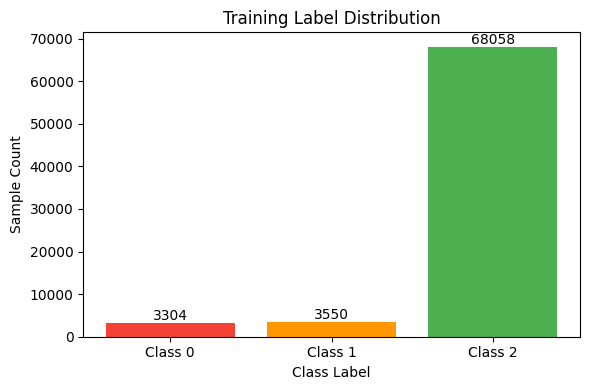

Optimizer parameter groups:
  Group 0: lr=2.0e-05, weight_decay=0.01, n_params=124645632
  Group 1: lr=2.0e-05, weight_decay=0.0, n_params=42755
Dataloaders ready — Train: 74912, Val: 16053, Test: 16053
Input data device: cpu


Epoch 01/2 | Train Loss: 0.5351, Val Loss: 0.2690 | Train Acc: 79.77%, Val Acc: 90.39% | Time: 16.27 min


Epoch 02/2 | Train Loss: 0.2513, Val Loss: 0.2951 | Train Acc: 92.29%, Val Acc: 89.46% | Time: 16.26 min

✅ Training complete in 32.53 min (975.98 sec/epoch avg)
⏱ Timing + environment info saved to: /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/roberta-cnn-gelu/roberta-cnn-gelu_timing_log.json
✅ Saved model graph to: /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/roberta-cnn-gelu/roberta-base_graph.png
Config saved → /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/roberta-cnn-gelu/roberta-cnn-gelu_config.json


Classification report saved → /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/roberta-cnn-gelu/roberta-cnn-gelu_classification_report.json
ROC-AUC plot saved → /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/roberta-cnn-gelu/roberta-cnn-gelu_roc_auc.png


In [ ]:
MODEL_NAME = "roberta-cnn-gelu"
MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
os.makedirs(MODEL_DIR, exist_ok=True)

# ---------------- CONFIG ----------------
CONFIG = {
    # -------- Model & Architecture --------
    "model_name": "roberta-base",
    "activation": "gelu",
    "hidden_size": 320,
    "dropout": 0.5,
    "fine_tune_base": True,
    "num_classes": 3,

    # -------- Tokenization & Data --------
    "max_len": 160,
    "batch_size": 128,

    # -------- Training --------
    "epochs": 2,
    "optimizer": "adamw",
    "loss_fn": "crossentropy",

    # -------- Learning Rates --------
    "lr_base": 2e-5,          # Transformer (BERT/Roberta/etc.)
    "lr_lstm": 2e-5,          # LSTM layer
    "lr_classifier": 2e-5,    # Classifier head

    # -------- Weight Decay --------
    "weight_decay_base": 0.01,  # Usually for pretrained encoder
    "weight_decay_others": 0.0, # Usually 0 for new layers

    # -------- Device --------
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}


# ---------------- Load tokenizer + transformer ----------------
tokenizer, base_model = load_base_model(CONFIG["model_name"])

# ---------------- Initialize model ----------------

model = TransformerCNNClassifier(
    base_model     = base_model,
    num_classes    = CONFIG["num_classes"],
    filter_sizes   = (2, 3, 4),
    num_filters    = 100,
    dropout        = CONFIG["dropout"],
    fine_tune_base = CONFIG["fine_tune_base"]
).to(CONFIG["device"])

# ---------------- Compute Class Weights ----------------
class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
print("Computed class weights:", weights_dict)

# --- Visualize class distribution ---
y_train_np = np.array(y_train_enc)
unique, counts = np.unique(y_train_np, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
plt.xticks(unique, [f"Class {c}" for c in unique])
plt.title("Training Label Distribution")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")

for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# ---------------- Optimizer and loss ----------------
optimizer = build_optimizer(
    model,
    optimizer_name     = CONFIG["optimizer"],
    lr_base            = CONFIG["lr_base"],
    lr_lstm            = CONFIG["lr_lstm"],
    lr_classifier      = CONFIG["lr_classifier"],
    weight_decay_base  = CONFIG["weight_decay_base"],
    weight_decay_others= CONFIG["weight_decay_others"]
)


criterion = build_loss(CONFIG["loss_fn"])

# ---------------- Dataloaders ----------------
train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
    X_train, y_train_enc,
    X_val,   y_val_enc,
    X_test,  y_test_enc,
    tokenizer,
    CONFIG["max_len"],
    CONFIG["batch_size"]
)

# Add a check for input data device before training
batch = next(iter(train_dataloader))
print(f"Input data device: {batch['input_ids'].device}")


# ---------------- Training ----------------
history = train_and_evaluate(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=CONFIG["device"],
    model_name=MODEL_NAME,  # safe filename
    model_dir=MODEL_DIR,
    epochs=CONFIG["epochs"]
)

# ---------------- Model Graph ----------------
save_model_graph(
    model,
    train_dataloader,
    CONFIG["model_name"],
    MODEL_DIR,
    CONFIG["device"],
    show_backbone=True
)

# ---------------- Evaluation ----------------
results = evaluate_model(
    model=model,
    test_loader=test_dataloader,
    label_encoder=label_enc,
    device=CONFIG["device"],
    model_name=MODEL_NAME,
    model_dir=MODEL_DIR,
    num_classes=CONFIG["num_classes"],
    train_acc_final=history["train_accs"][-1],
    config=CONFIG
)